In [1]:
import numpy as np
import h5py
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('poster')

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

def centroids(X,label=None):
    if label is not None:
        cLabel = np.unique(label)
        c = np.zeros((len(cLabel), X.shape[1]))
        for i,l in enumerate(cLabel):
            c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    else:
        c = bipolarize(np.sum(X,axis=0)).reshape(1,-1)
        cLabel = [0]
    return cLabel, c.astype('int')

def classify(v,am,metric):
    d = cdist(v,am,metric)
    label = np.argmin(d,axis=1)
    return label

In [3]:
dataFile = 'data.mat'
file = h5py.File(dataFile,'r')
experimentData = file['experimentData']
keys = list(experimentData.keys())
numTrials, numPositions, numGestures = experimentData[keys[0]].shape
D = file[experimentData[keys[3]][0,0,0]].shape[1]
numEx = 80

In [4]:
xRange = 10000
yRange = 5000
zRange = 6000
CIMRanges = (xRange, yRange, zRange)
xQuant = 59
yQuant = 55
zQuant = 14
NQuants = (xQuant, yQuant, zQuant)

# xRange = 5000
# yRange = 5000
# zRange = 5000
# CIMRanges = (xRange, yRange, zRange)
# xQuant = 64
# yQuant = 64
# zQuant = 64
# NQuants = (xQuant, yQuant, zQuant)

ims = []
for i in range(3):
    im = np.zeros((NQuants[i],D))
    seed = np.random.choice([-1.0, 1.0], size=D)
    flipBits = np.random.permutation(D)
    numFlip = np.round(np.linspace(0,CIMRanges[i],NQuants[i])).astype('int')
    for x in range(NQuants[i]):
        im[x,:] = seed
        im[x,flipBits[:numFlip[x]]] *= -1
    ims.append(im)

In [5]:
totalEx = numEx*numGestures*numPositions*numTrials

hv = np.zeros((totalEx,D),dtype=np.int8)
gestLabel = np.zeros(totalEx,dtype='int')
posLabel = np.zeros(totalEx,dtype='int')

idx = np.arange(numEx).astype('int')
for g in tqdm(range(numGestures)):
    for p in range(numPositions):
        for t in range(numTrials):
            expLabel = file[experimentData['expGestLabel'][t,p,g]][0,:]
            r = file[experimentData['emgHV'][t,p,g]][expLabel>0,:]
            accFeat = file[experimentData['accFeat'][t,p,g]][:,expLabel>0].T
            
            accIdx = np.zeros(accFeat.shape,dtype='int')
            for ax in range(3):
                accIdx[:,ax] = np.floor((accFeat[:,ax] + 1)/2*(NQuants[ax])).astype('int')
                accIdx[accIdx[:,ax] < 0,ax] = 0
                accIdx[accIdx[:,ax] > NQuants[ax]-1,ax] = NQuants[ax]-1
            
            xHV = ims[0][accIdx[:,0]]
            yHV = ims[1][accIdx[:,1]]
            zHV = ims[2][accIdx[:,2]]
            
            hv[idx,:] = r*xHV*yHV*zHV

            gestLabel[idx] = g
            posLabel[idx] = p
            idx += numEx

100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


In [6]:
combGP, groupGP = np.unique(np.column_stack((gestLabel,posLabel)),axis=0,return_inverse=True)
gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
numGestures = len(gestures)
numPositions = len(positions)

In [7]:
numIter = 10

accSin = np.zeros((numPositions,numPositions))
accSup = np.zeros(numPositions)
accSupP = np.zeros(numPositions)
    
for nn in range(numIter):
    numSplit = 10
    skf = StratifiedKFold(n_splits=numSplit)

    X = hv
    y = gestLabel
    c = posLabel
    g = groupGP

    accSingle = np.zeros((numPositions,numPositions,numSplit))
    accSuperProto = np.zeros((numPositions,numSplit))
    accSuper = np.zeros((numPositions,numSplit))

    splitIdx = 0

    for trainIdx, testIdx in tqdm(skf.split(X,g)):
    #     print('Running iteration %d of %d...' % (splitIdx+1, numSplit))
        XTrain, XTest = X[trainIdx], X[testIdx]
        yTrain, yTest = y[trainIdx], y[testIdx]
        cTrain, cTest = c[trainIdx], c[testIdx]
        gTrain, gTest = g[trainIdx], g[testIdx]

        # generate a separate prototype for each gesture and arm position
        pLabel, p = centroids(XTrain,label=gTrain)

        # classify with each arm position only
        for pos in positions:
            AM = np.vstack([x for i,x in enumerate(p) if combGP[pLabel[i]][1] == pos])
            pred = classify(XTest,AM,'cosine')
            for posTest in positions:
                accSingle[pos,posTest,splitIdx] = accuracy_score(pred[cTest == posTest], yTest[cTest == posTest])

        # classify with superimposed arm positions - superimposed prototypes
        pLabel, p = centroids(p,label=combGP[:,0])
        pred = classify(XTest,p,'cosine')
        for posTest in positions:
            predLabel = [pLabel[pr] for pr in pred[cTest == posTest]]
            accSuperProto[posTest,splitIdx] = accuracy_score(predLabel,yTest[cTest == posTest])

        # classify with superimposed arm positions - superimposed examples
        pLabel, p = centroids(XTrain,label=yTrain)
        pred = classify(XTest,p,'cosine')
        for posTest in positions:
            predLabel = [pLabel[pr] for pr in pred[cTest == posTest]]
            accSuper[posTest,splitIdx] = accuracy_score(predLabel,yTest[cTest == posTest])

        splitIdx += 1

    accSin += np.mean(accSingle,axis=2)/numIter
    accSupP += np.mean(accSuperProto,axis=1)/numIter
    accSup += np.mean(accSuper,axis=1)/numIter
    
accSingle = accSin
accSuperProto = accSupP
accSuper = accSup

10it [00:55,  5.59s/it]
10it [00:53,  5.33s/it]
10it [00:57,  5.74s/it]
10it [00:57,  5.70s/it]
10it [00:54,  5.42s/it]
10it [00:52,  5.29s/it]
10it [00:53,  5.39s/it]
10it [00:55,  5.52s/it]
10it [01:06,  6.69s/it]
10it [00:59,  5.90s/it]


In [8]:
accIn = np.zeros(numPositions)
accOut = np.zeros(numPositions)
accAll = np.zeros(numPositions)
for p in positions:
    accIn[p] = np.mean(accSingle[p][positions == p])
    accOut[p] = np.mean(accSingle[p][positions != p])
    accAll[p] = np.mean(accSingle[p])
    
print('AccIn = %.2f%%' % (np.mean(accIn)*100), end=' ')
print(['%.2f%%' % d for d in accIn*100])

print('AccOut = %.2f%%' % (np.mean(accOut)*100), end=' ')
print(['%.2f%%' % d for d in accOut*100])

print('AccAll = %.2f%%' % (np.mean(accAll)*100), end=' ')
print(['%.2f%%' % d for d in accAll*100])

print('AccSuper = %.2f%%' % (np.mean(accSuper)*100), end=' ')
print(['%.2f%%' % d for d in accSuper*100])

print('AccSuperProto = %.2f%%' % (np.mean(accSuperProto)*100), end=' ')
print(['%.2f%%' % d for d in accSuperProto*100])

AccIn = 96.63% ['99.77%', '99.82%', '94.65%', '99.84%', '99.97%', '99.79%', '91.12%', '88.12%']
AccOut = 37.24% ['39.31%', '46.45%', '41.20%', '39.90%', '35.09%', '45.23%', '27.61%', '23.13%']
AccAll = 44.66% ['46.86%', '53.12%', '47.88%', '47.39%', '43.20%', '52.05%', '35.55%', '31.25%']
AccSuper = 89.19% ['99.06%', '97.74%', '73.70%', '99.29%', '98.97%', '93.96%', '74.28%', '76.54%']
AccSuperProto = 89.27% ['98.78%', '98.57%', '71.08%', '97.58%', '98.63%', '94.55%', '79.13%', '75.85%']


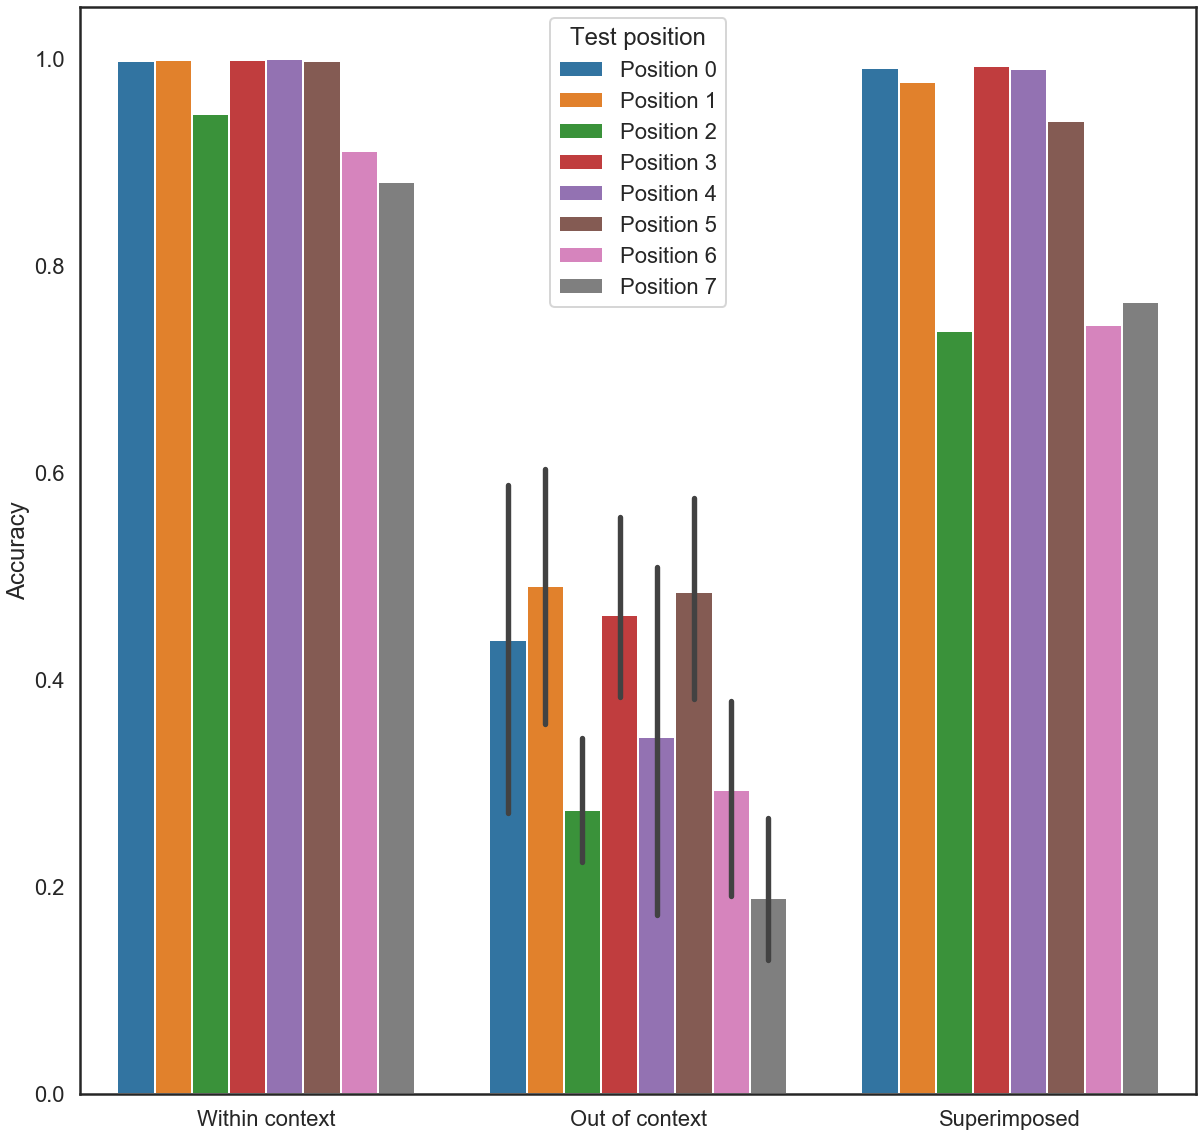

In [9]:
acc = pd.DataFrame(columns=('Accuracy','Train position','Test position','Type'))
idx = 0
for pTrain in range(numPositions):
    for pTest in range(numPositions):
        if pTrain == pTest:
            acc.loc[idx] = [accSingle[pTrain,pTest],'Position %d' % pTrain,'Position %d' % pTest,'Within context']
        else:
            acc.loc[idx] = [accSingle[pTrain,pTest],'Position %d' % pTrain,'Position %d' % pTest,'Out of context']
        idx += 1

for pTest in range(numPositions):
    acc.loc[idx] = [accSuper[pTest],'Superimposed examples','Position %d' % pTest,'Superimposed']
    idx += 1
#     acc.loc[idx] = [accSuperProto[pTest],'Superimposed prototypes','Position %d' % pTest,'Superimposed']
#     idx += 1

f,ax = plt.subplots(figsize=(20,20))
sns.barplot(data=acc,x='Type',y='Accuracy',hue='Test position',ax=ax)
ax.set_xlabel('')
plt.show()

In [10]:
np.savez('encoding_imu.npz',accSingle=accSingle,accSuperProto=accSuperProto,accSuper=accSuper)